In [1]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from skimage import io, img_as_ubyte
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as preproc
import py_pcha
from sklearn.neighbors import KNeighborsClassifier
import random
import copy


import seaborn as sns

In [2]:
# Globals
_SEED = 0

In [3]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

In [4]:
# Read labels as pandas object from labels.csv
labels_columns = ['age', 'gender', 'race']
labels = pd.read_csv(labels_path)
labels = pd.DataFrame(data=labels.values, columns=labels_columns)

In [5]:
# filter labels
def filter_by_age(df, fromAge, toAge):
    return df[(df.age >= fromAge) & (df.age <=toAge)]

In [6]:
filtered_labels = filter_by_age(labels, 60,65 )
filtered_labels

,age,gender,race
20349,60,0,0
20350,60,0,0
20351,60,0,0
20352,60,0,0
20353,60,0,0
...,...,...,...
21333,65,1,3
21334,65,1,3
21335,65,1,3
21336,65,1,4


In [7]:
# Open a random image to get dimensions
test_img_name = 0
test_img = io.imread(faces_path+f"{test_img_name}.jpg", as_gray=True)
h, w = test_img.shape
del test_img

In [8]:
#Select images from dataset using filtered_labels
X = np.empty((len(filtered_labels), h*w))

for i, index in enumerate(filtered_labels.index):
    #print(i,index)
    a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
    a = img_as_ubyte(a)
    X[i, :] = a.reshape(1, -1)
    
del a
print('Done loading images')

Done loading images


In [9]:
n_components = 9 # num components

In [10]:
#Archetypal analysis (KNN commented out)
# Does not require that you center data
XC, S, C, SSE, varexpl = py_pcha.PCHA(X.T, noc=n_components, delta=0.1)
X_hat = X.T @ C @ S
L = 0.5*np.linalg.norm(X.T-X_hat)**2
components = XC.T
SST = np.sum(np.sum(X**2))


#knn.fit(S.T,ytrain)
# Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S
#acc = knn.score(Xtest_transform.T,ytest)
# X_test_hat = (XC @ Xtest_transform).T

#Reference to book notation
#B = C.T
#W = S.T
#H = XC.T
#SSE = Sum of Squared Errors

In [13]:
#Get indexes of the samples more significant for the archetypes
Xmain = np.zeros((n_components,3))

for i in range(len(C.T)):
    Xmain[i,:] = np.flip(np.argsort(C.T[i]))[0,:3]
Xmain = Xmain.astype(int) #Main samples indexes for each component
    
arch_len = np.array(range(len(Xmain))).reshape(-1,1)
arch_main = np.append(arch_len, Xmain, axis = 1) #Archetype indexes and main samples indexes

In [20]:
#Plotting functions
n_rows = 7 #for plotting
n_cols = 7 #for plotting

left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (h, w)
# Function for plotting images
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    #start_index = random.randint(0, n)
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 210)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_arch_contributors(title, arch_main):
    '''
    Plot each archetype (first column) and the three most contributive samples that 
    define them
    '''
    #plt.figure(figsize=(image_shape[0]/100 * n_components, image_shape[1]/100 * np.shape(arch_main)[1]))
    plt.figure(figsize= (image_shape[1]/90 * np.shape(arch_main)[0], image_shape[0]/40 * n_components))
    plt.suptitle(title, size=24)
    pos = 0
    j = 0
    while j < len(arch_main):  
        for i, sample in enumerate(arch_main[j]):
            pos += 1
            if i == 0:
                comp = XC.T[sample,:]
            else:
                comp = X[sample,:]
            plt.subplot(n_components, np.shape(arch_main)[1], pos)
            # normalize colormap
            vmax = max(comp.max(), -comp.min())
            plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                       interpolation='nearest',
                       vmin=-vmax, vmax=vmax)
            # Remove ticks from plot
            plt.xticks(())
            plt.yticks(())
        j += 1

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

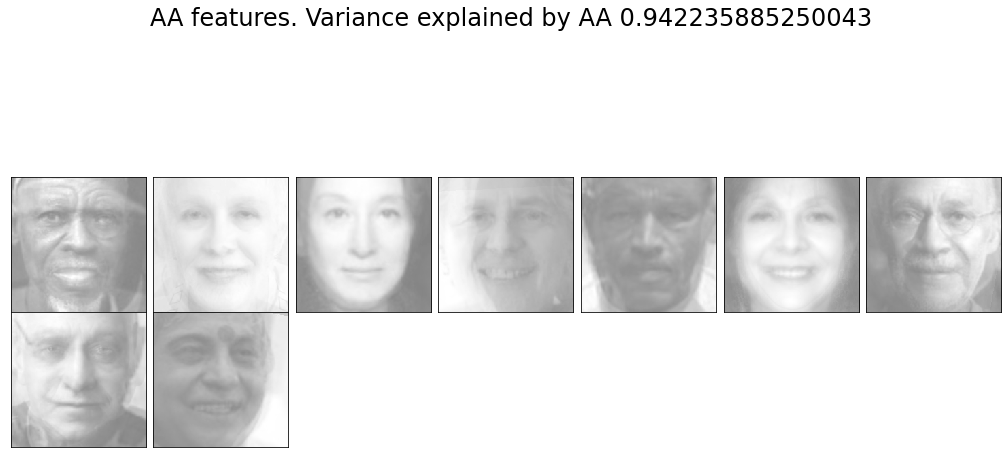

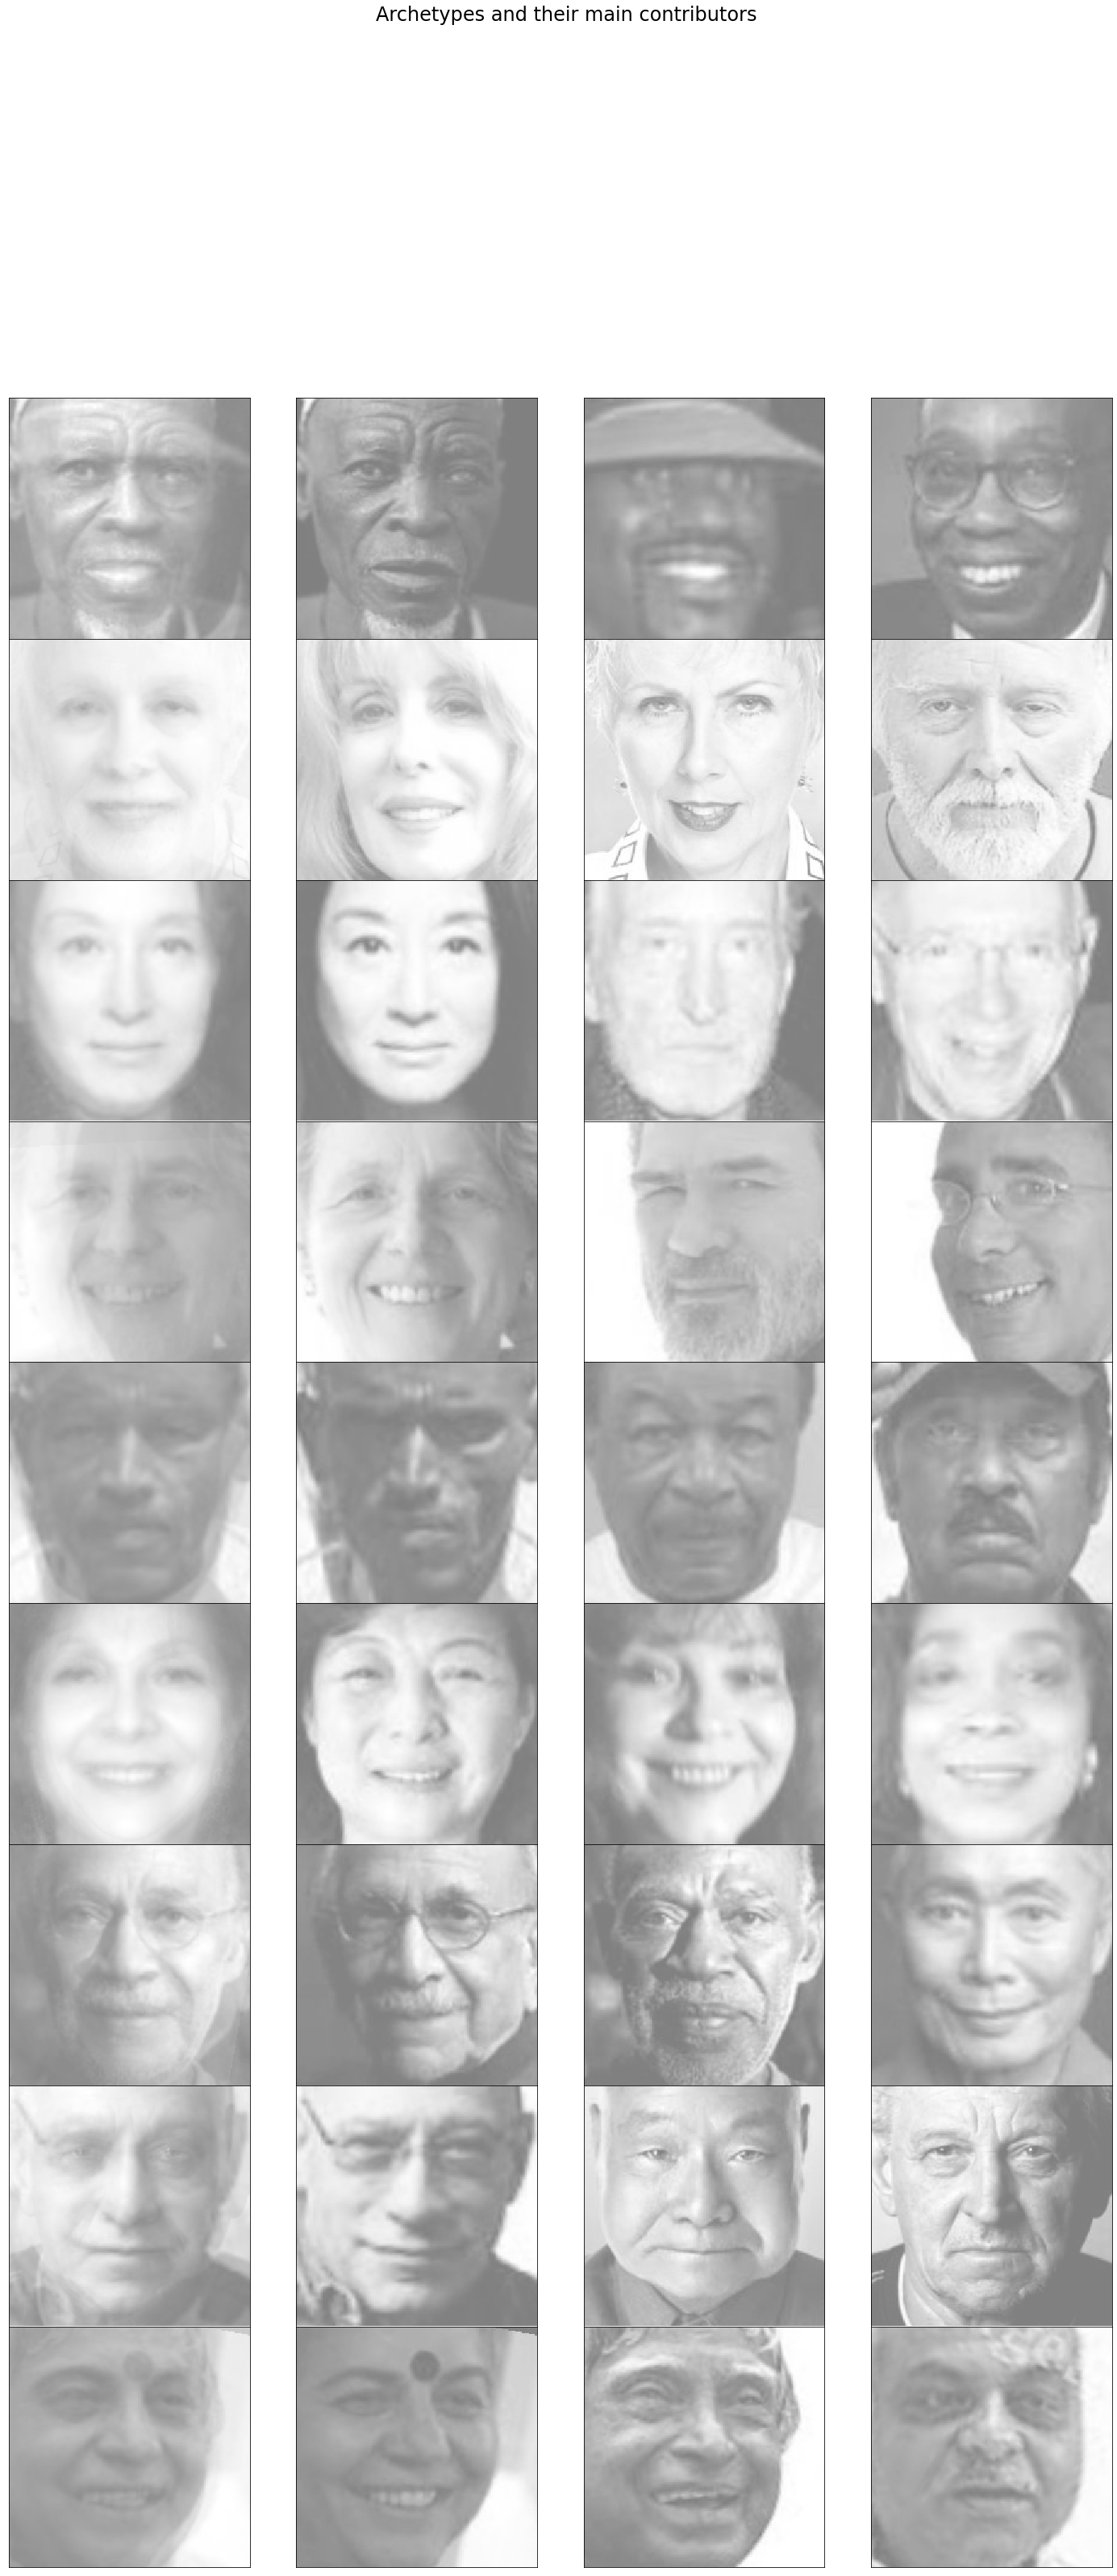

In [21]:
plot_components(f'AA features. Variance explained by AA {1-2*L/SST}', components)
# plot_recons(X_hat, f'AA reconstructed digits')
plot_arch_contributors('Archetypes and their main contributors', arch_main)

In [22]:
#Switch lables_codes to words
labels_words = copy.deepcopy(filtered_labels)

#gender
labels_words.loc[labels_words.gender == 0, "gender"] = "0_male"
labels_words.loc[labels_words.gender == 1, "gender"] = "1_female"

#race
labels_words.loc[labels_words.race == 0, "race"] = "0_white"
labels_words.loc[labels_words.race == 1, "race"] = "1_black"
labels_words.loc[labels_words.race == 2, "race"] = "2_asian"
labels_words.loc[labels_words.race == 3, "race"] = "3_indian"
labels_words.loc[labels_words.race == 4, "race"] = "4_others"

#age in bins
bins = [0, 2, 4, 13, 20, 60, 200]
lab = ["0_infant", "1_toddler", "2_kid", "3_teen", "4_adult", "5_old"]
labels_words["age"] = pd.cut(labels_words["age"], bins = bins, labels = lab)

In [52]:
#Score matrix, used to understand which labels constitute each component
def arch_score(B, labels):
    '''
    Arguments:
    labels = pandas df. Make sure that the values are unique across the whole dataset. 
             If there is an "A" in the first column, it must not be there in the others
    B = n_component * n_samples (C.T). Every row describes the coefficient for each sample to 
        build the corresponding archetype
    _____________________________________________________________________________________
    Output:
    score_matrix = n_component * possible labels values. Every case describes how much the 
                    corresponding label is present in the component
    '''
    #Get all the unique values of the various labels, sorted   
    cols = []
    for i in range(labels.shape[1]):
        cols += sorted(list(labels.iloc[:,i].unique()))
    labels_values = np.array(cols) #List of the possible values of the labels, ordered "inside" each column
    print("Labels:",labels_values)
    score_matrix = np.zeros(shape=(np.shape(B)[0], len(labels_values)))
    
    for component_i in range(np.shape(score_matrix)[0]):
        for label_i in range(len(list(labels_values))):
            for sample_i in range(np.shape(B)[1]):
                if labels_values[label_i] in list(labels.iloc[sample_i,:]):
                    score_matrix[component_i, label_i] += B[component_i,sample_i]
    
    return score_matrix, labels_values

In [53]:
archetype_scores, score_labels = arch_score(B = C.T, labels = labels_words)

Labels: ['4_adult' '5_old' '0_male' '1_female' '0_white' '1_black' '2_asian'
 '3_indian' '4_others']


In [50]:
mean_component_score = S.T[0] @ archetype_scores
mean_component_score

matrix([[0.29437698, 0.80562302, 0.89729269, 0.20270731, 0.28284037,
         0.52280133, 0.02141553, 0.27294276, 0.        ]])

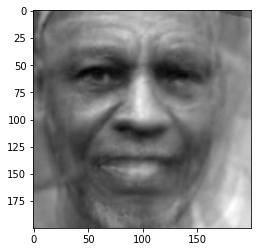

In [48]:
plt.imshow((X_hat.T[0,:]).reshape(h,w), cmap='gray')

In [76]:
#Find the most similar component (switched gender) to the average of the components of the input
female_index = list(np.where(score_labels == '1_female'))
male_index = list(np.where(score_labels == '0_male'))
gender_indices = female_index + male_index

distances = np.zeros(np.shape(archetype_scores)[0])

for r in range(np.shape(archetype_scores)[0]):
    distance = np.linalg.norm(archetype_scores[r,:] - mean_component_score)
    mf = np.linalg.norm(archetype_scores[r,gender_indices] - mean_component_score[0,gender_indices])
    
    distances[r] = distance - 2 * mf
    
winner_index = np.argmin(distances)
winner_index

5

In [101]:
#Gender-switch functions
def gender_switch_component_index(wj, labels, scores):
    '''
    Input:
    wj = row in matrix W corresponding to the image to switch gender of
    labels = list of the possible labels in the components scores matrix
             (output of the function arch_score)
    scores = n_components * n_labels . Components scores matrix (output of the function arch_score)
    ___________________________________________________________________________________
    
    Output:
    winner_index = index of the selected component. Increase this component
                    to switch gender
    '''
    #Find the weighted average of the components scores of the input 
    mean_component_score = wj @ scores
    
    #Get the indexes of the genders
    f_i = list(np.where(labels == '1_female'))
    m_i = list(np.where(labels == '0_male'))
    gender_i = f_i + m_i
    distances = np.zeros(np.shape(scores)[0])

    for r in range(np.shape(scores)[0]):
        distance = np.linalg.norm(scores[r,:] - mean_component_score)
        mf = np.linalg.norm(scores[r,gender_i] - mean_component_score[0,gender_i])

        distances[r] = distance - 2 * mf

    winner_index = np.argmin(distances)
    
    return winner_index

def add_component(wj, comp_i, coefficient=0.3):
    '''
    Input
    wj = row in matrix W corresponding to the image to switch gender of
    comp_i = index of the component to add
    coefficient = [0-1] How much to increase the new component
    ____________________________________________________________________
    Output
    new = coefficients of the components to reconstruct the new image
    '''
    new = copy.deepcopy(wj) #Deepcopy to not mess with original matrix
    
    #Proportionally decrease old components 
    for component in range(len(new)):
        new[component] = new[component] * (1 - coefficient)
    
    #Add new component
    new[0, comp_i] += winner_coefficient
    
    return new

In [102]:
win = gender_switch_component_index(wj=S.T[0], labels=score_labels, scores=archetype_scores)
print(win)

5


In [79]:
new_gender_w

matrix([[0.42277552, 0.        , 0.        , 0.        , 0.15813698,
         0.        , 0.04807053, 0.        , 0.17101697]])

In [84]:
winner_coefficient = 0.3
new_gender_w = copy.deepcopy(S.T[0,:])
for component in range(len(new_gender_w)):
    new_gender_w[component] = new_gender_w[component] * (1 - winner_coefficient)
new_gender_w[0, winner_index] += winner_coefficient

In [85]:
new_gender_w

matrix([[0.36992858, 0.        , 0.        , 0.        , 0.13836986,
         0.3       , 0.04206171, 0.        , 0.14963985]])

In [105]:
new_gender_w = add_component(wj=S.T[0], comp_i=win, coefficient=0.3)

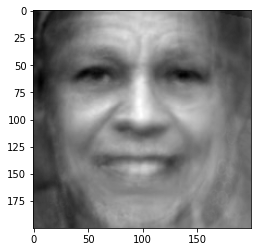

In [106]:
new_fem = new_gender_w @ XC.T
plt.imshow((new_fem[0,:]).reshape(h,w), cmap='gray')